In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Cleaner as c

time: 3.56 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.37 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 472 µs


In [5]:
cl = c.Cleaner(database_name)

time: 1.56 ms


## Half Term Data

In [6]:
# creating dataframe
df = cl.data_prep_half(120)

# cleaning data frame
drops = ['row_id', 'studied_credits',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date', 'activity_level']

df = cl.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 11 s


In [7]:
# saving columns as series for use in error data frame
final_result = df['final_result'].copy()
code_module = df['code_module'].copy()
code_presentation = df['code_presentation'].copy()

time: 2.52 ms


In [8]:
# dropping columns
df = df.drop(['final_result', 'code_presentation', 'id_student'], axis=1)

time: 5.74 ms


## Splitting The Data

In [9]:
# splitting data & target
X, y = f.X_y(df)

time: 2.88 ms


In [10]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 13.7 ms


## Recreating The Test Data

In [11]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 11 ms


## Loading Model

In [12]:
model = f.load_model('final')

time: 416 ms


## Error Data Frame

In [13]:
# getting predictions
y_pred = model.predict(X_test)

# creating the errors data frame
errors = X_test.copy()

# adding the true binary outcome column
errors['result'] = y_test

# adding the predicted binary outcome column
errors['prediction'] = y_pred

# adding the true multiclass labels
errors['label'] = final_result

# adding the code module column
errors['code_module'] = code_module

# adding the code presentation column
errors['code_presentation'] = code_presentation

time: 99.8 ms


In [14]:
# checking the info
errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3649 entries, 10335 to 14520
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                3649 non-null   object  
 1   region                3649 non-null   object  
 2   highest_education     3649 non-null   object  
 3   imd_band              3649 non-null   object  
 4   age_band              3649 non-null   object  
 5   num_of_prev_attempts  3649 non-null   float64 
 6   disability            3649 non-null   object  
 7   weighted_ave          3649 non-null   float64 
 8   mean_score            3649 non-null   float64 
 9   median_score          3649 non-null   float64 
 10  code_module           3649 non-null   object  
 11  sum_activity          3649 non-null   float64 
 12  course_load           3649 non-null   category
 13  result                3649 non-null   float64 
 14  prediction            3649 non-null   float64 
 15 

## Outcome Error Rates

In [15]:
# getting the label counts
label_counts = errors.label.value_counts()

# getting each label's error count
label_errors = errors[errors['result'] != errors['prediction']]['label'].value_counts()

# calculating each label's error rate
error_rates = label_errors/label_counts

# calculating the total number of errors
total_errors = label_errors.sum()

# calculating each label's share of the errors
share_total_errors = label_errors/total_errors

time: 8.16 ms


In [16]:
# checking the error rates
error_rates

Distinction    0.010230
Fail           0.332308
Pass           0.165468
Withdrawn      0.391691
Name: label, dtype: float64

time: 4.8 ms


In [17]:
# checking each label's share of total errors
share_total_errors

Fail           0.414322
Pass           0.411765
Withdrawn      0.168798
Distinction    0.005115
Name: label, dtype: float64

time: 2.72 ms


## Outcome Error Rates

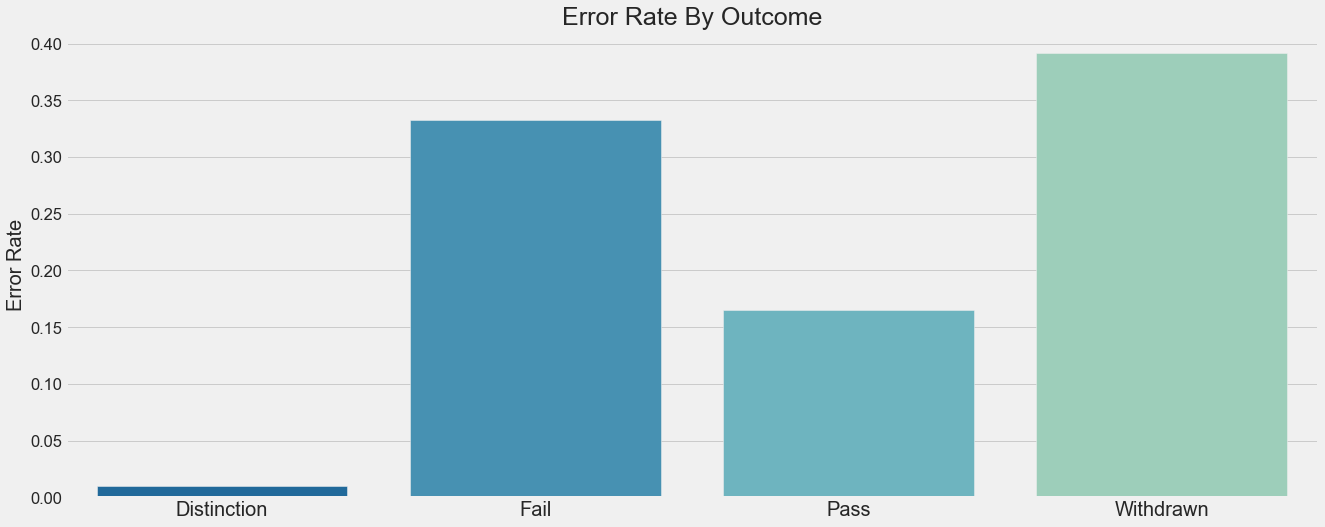

time: 207 ms


In [18]:
v.error_rate(errors)

In [19]:
# checking each label's share of the data
normalized_counts = errors.label.value_counts(normalize=True)
normalized_counts

Pass           0.533297
Fail           0.267196
Distinction    0.107153
Withdrawn      0.092354
Name: label, dtype: float64

time: 4.15 ms


Checking the error rates for each of the multiclass outcomes shows why the model is having trouble with the Unsatisfactory class; Withdrawn and Fail both have an error rate above 30%. Calculating the share of each class in the modeling data, we find an almost 3:2 class imbalance between the Satisfactory and Unsatisfactory classes. A multiclass classifier with oversampling might improve performance on this data.

## Numerical Feature Error Analysis

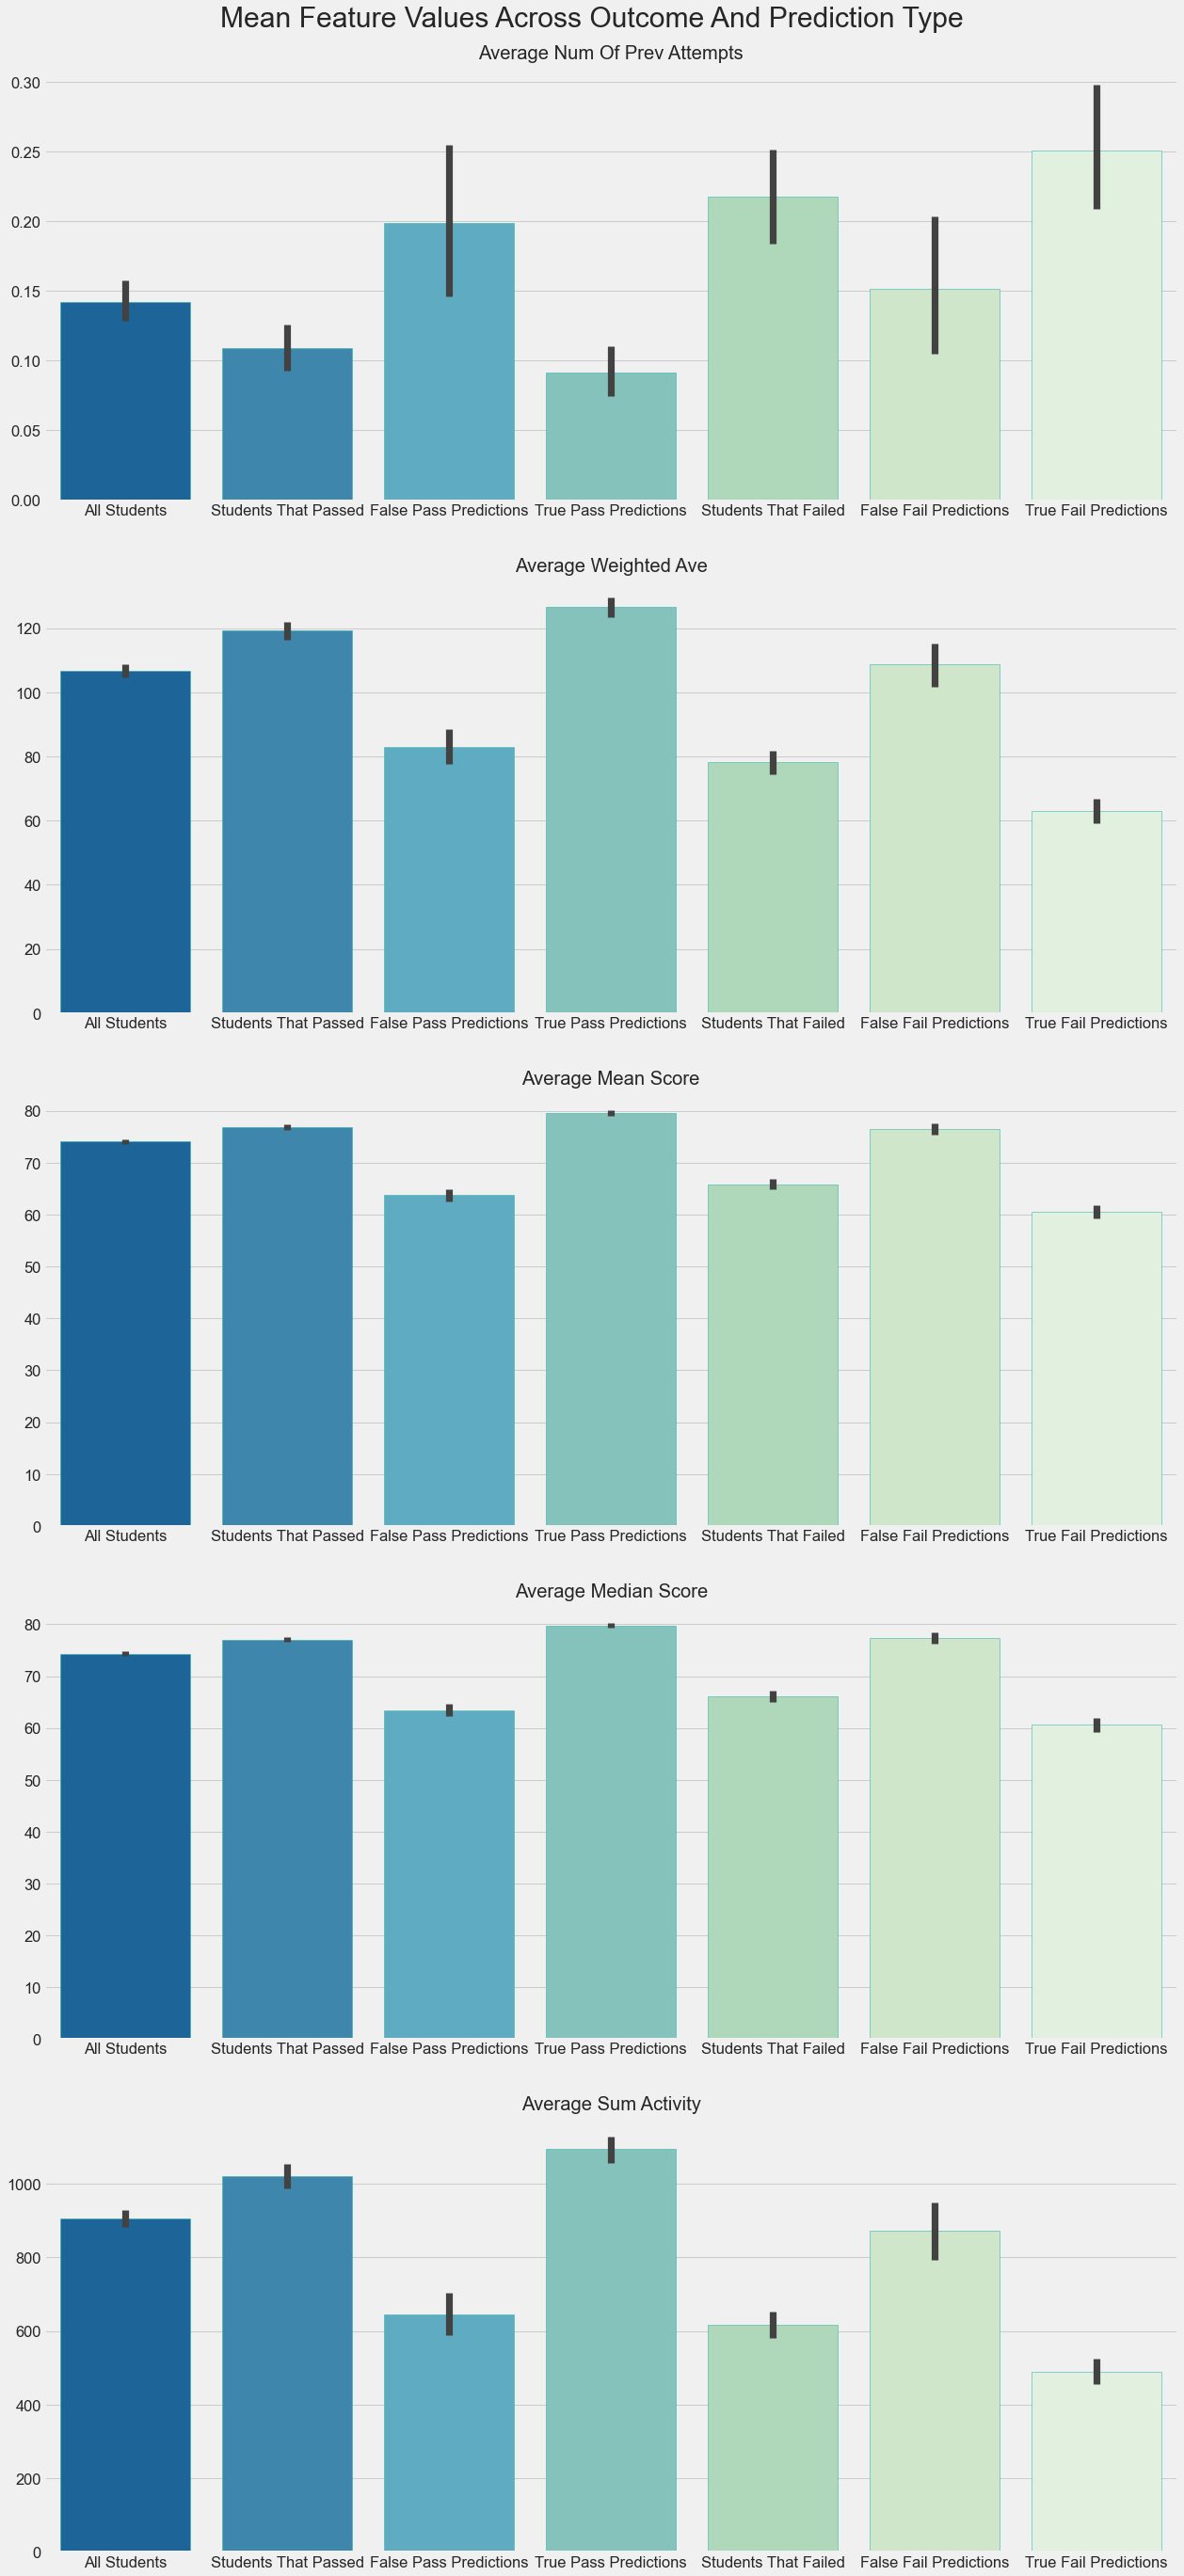

time: 1.87 s


In [20]:
num_cols = ['num_of_prev_attempts','weighted_ave','mean_score',
            'median_score','sum_activity']
v.numerical_errors(errors, num_cols)

## Categorical Feature Error Analysis

In [21]:
# dropping numerical features
drops = ['num_of_prev_attempts','weighted_ave', 'mean_score',
            'median_score', 'sum_activity']
cat_errors = errors.drop(columns=drops).reset_index()
# creating true predictions column
cat_errors['true_prediction'] = np.where(errors['prediction'] == errors['result'], True, False)
# dropping extraneous columns
cat_errors = cat_errors.drop(columns = ['result', 'prediction', 'label'])

time: 4.79 ms


In [22]:
# checking work
cat_errors.head()

,index,gender,region,highest_education,imd_band,age_band,disability,code_module,course_load,code_presentation,true_prediction
0,10335,Female,South East Region,Lower Than A Level,80-90%,0-35,No,DDD,Light,2014B,True
1,13638,Male,East Midlands Region,Lower Than A Level,20-30%,0-35,Yes,FFF,Light,2013B,True
2,4224,Male,East Midlands Region,Lower Than A Level,40-50%,35-55,No,BBB,Light,2014J,False
3,17028,Male,Ireland,A Level or Equivalent,40-50%,0-35,No,FFF,Heavy,2014J,True
4,11963,Male,Yorkshire Region,A Level or Equivalent,30-40%,0-35,No,EEE,Light,2013J,True


time: 45.9 ms


## Rate of Correct Predictions By Categorical Feature

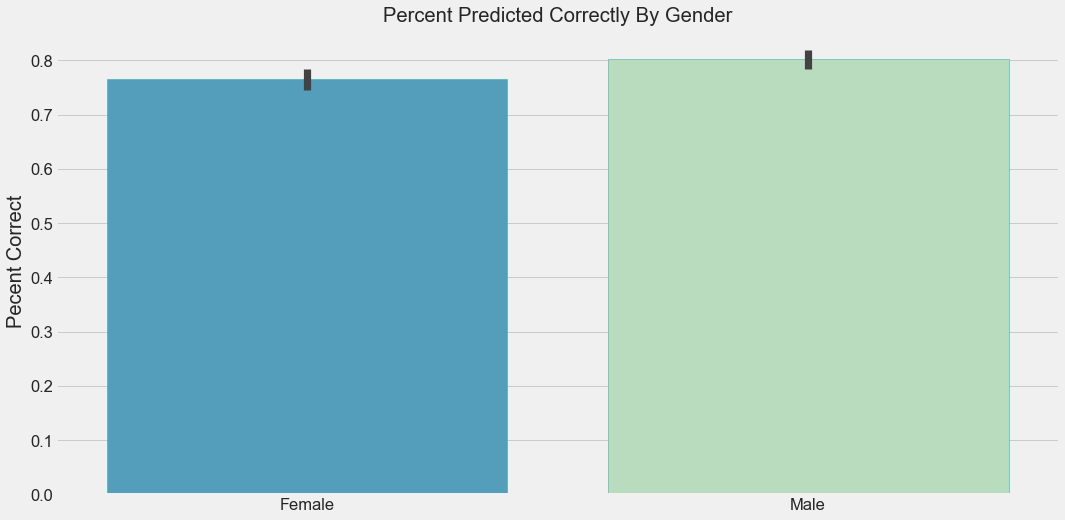

time: 206 ms


In [23]:
v.categorical_errors(cat_errors, 'gender')

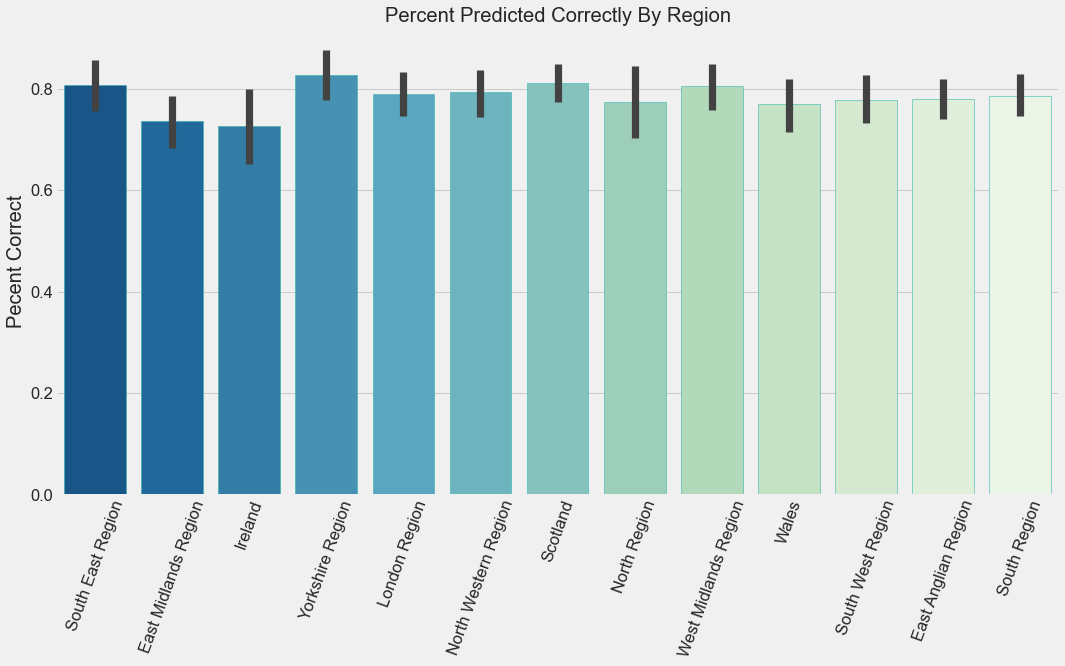

time: 457 ms


In [24]:
v.categorical_errors(cat_errors, 'region', 70)

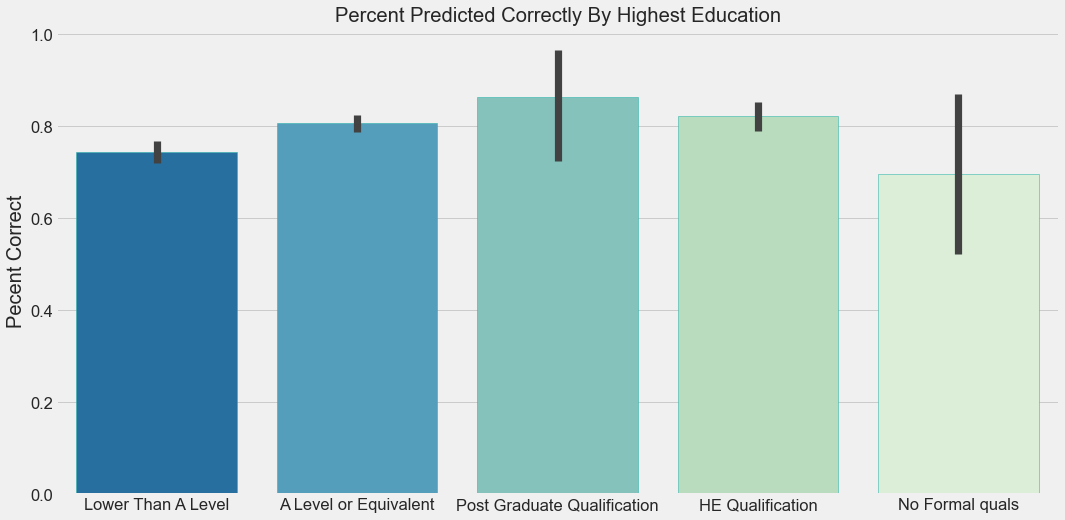

time: 239 ms


In [25]:
v.categorical_errors(cat_errors, 'highest_education')

Interestingly, both the lowest and highest education levels show the highest variance, but Post Grad Qualification has the highest correct rate, while No Formal quals has the lowest.

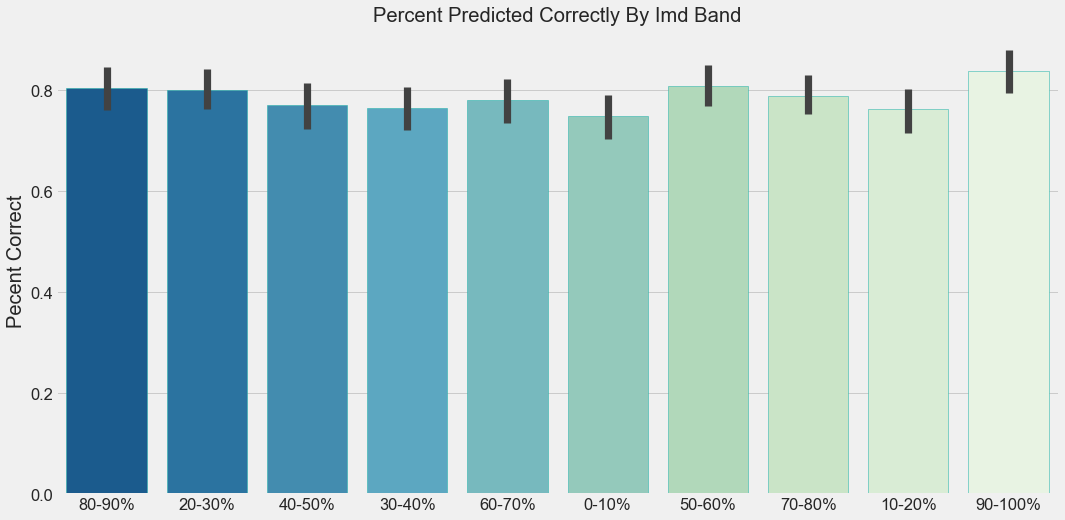

time: 364 ms


In [26]:
v.categorical_errors(cat_errors, 'imd_band')

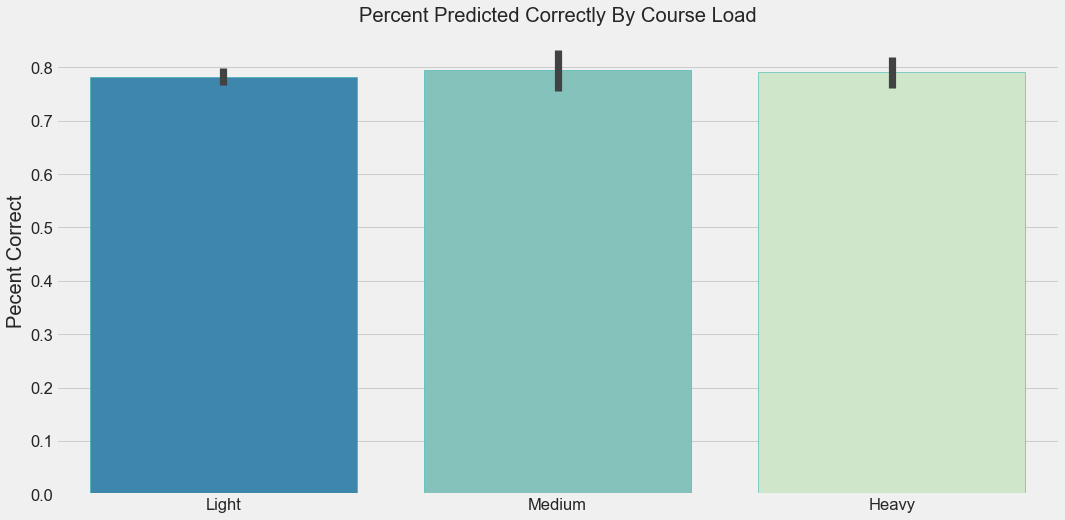

time: 210 ms


In [27]:
v.categorical_errors(cat_errors, 'course_load')

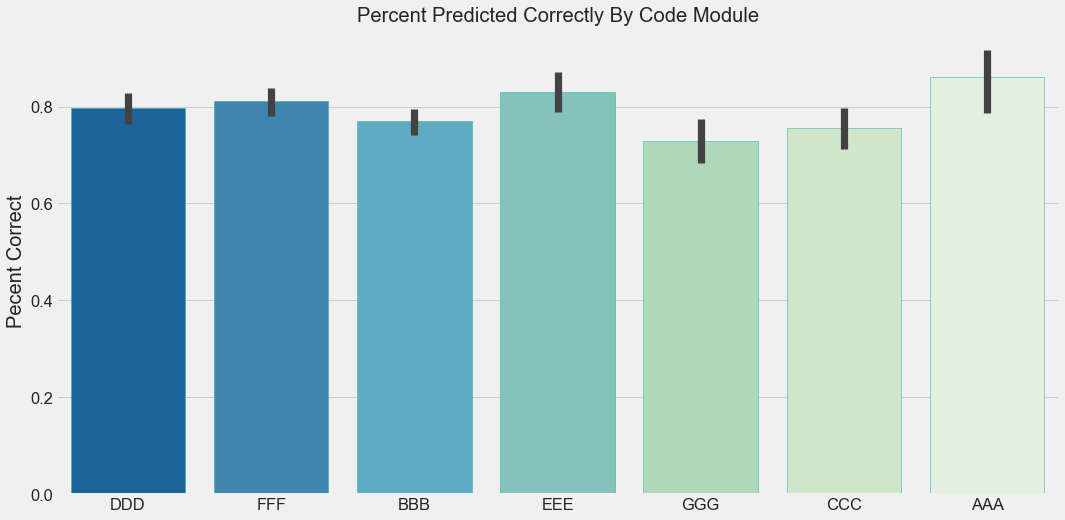

time: 296 ms


In [28]:
v.categorical_errors(cat_errors, 'code_module')

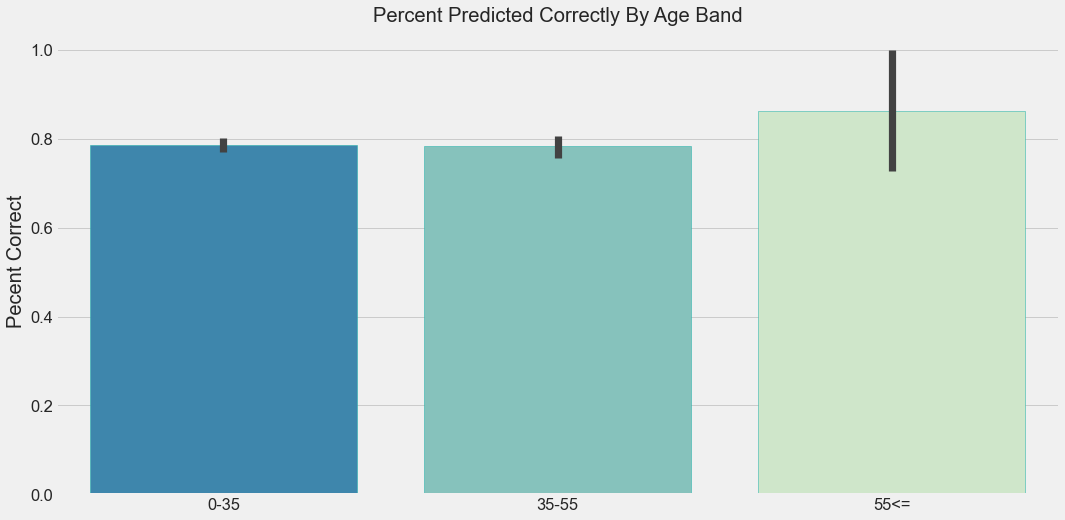

time: 209 ms


In [29]:
v.categorical_errors(cat_errors, 'age_band')

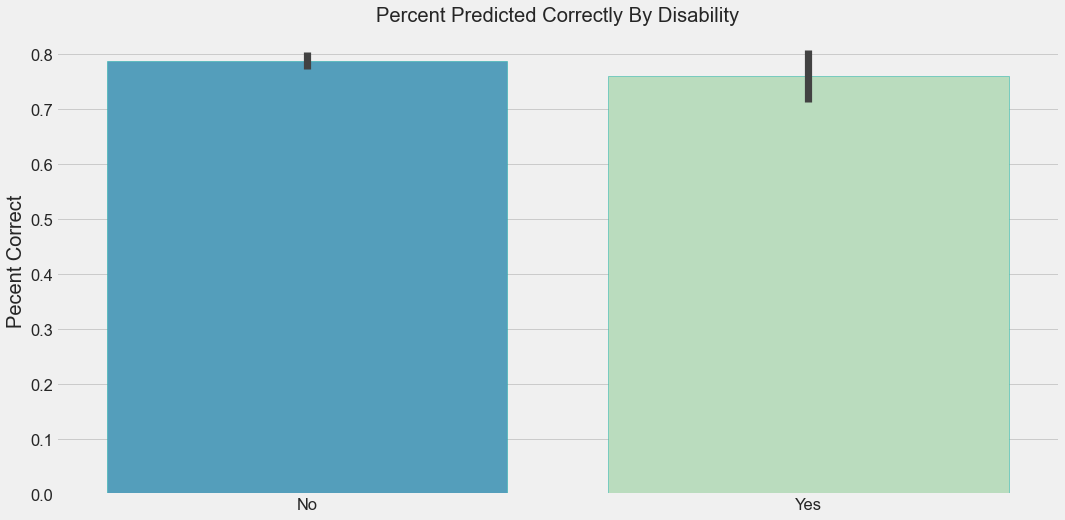

time: 181 ms


In [30]:
v.categorical_errors(cat_errors, 'disability')

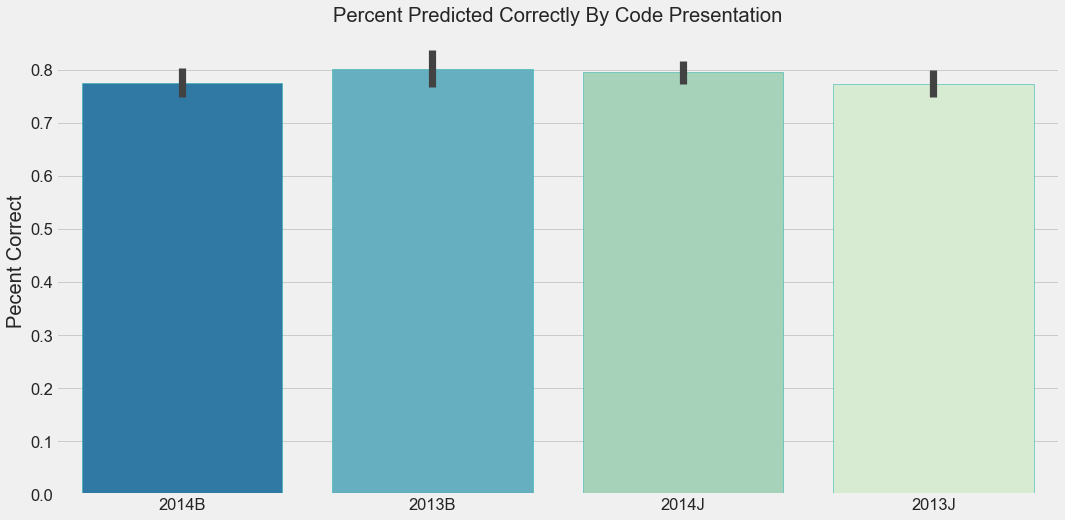

time: 228 ms


In [31]:
v.categorical_errors(cat_errors, 'code_presentation')